# Global mean Sea Surface Temperatures

In [36]:
import numpy as np
import xarray as xr
import pandas as pd

In [37]:
from calendar import monthrange

In [39]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

In [67]:
from globales import *

In [41]:
import multiprocessing
from dask.distributed import Client, LocalCluster

n_cores = multiprocessing.cpu_count()

cluster = LocalCluster(n_workers=10, threads_per_worker=1)
client = Client(cluster)

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35181 instead
  warnings.warn(


In [42]:
client.dashboard_link

'http://127.0.0.1:35181/status'

## Load data

In [43]:
base_file = GlobalSU['DatPath'] + '/Satelite/MUR/NC/'

In [44]:
year1= 2003
year2= 2024
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [45]:
iy=2025
for im in range(1,12):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [46]:
def drop_coords(ds):
    ds = ds.get(['analysed_sst'])
    return ds.reset_coords(drop=True)

DS = xr.open_mfdataset(files,combine='nested', concat_dim="time", parallel=True, combine_attrs= "drop", preprocess=drop_coords,autoclose = True, data_vars='minimal', coords="minimal", chunks={"time": 8036})


In [56]:
## Upwelling CCLME
#Xr=[-9.7299+360,  -15.2693+360,  -16.0000+360, -17.7162+360];
#Yr=[32.1623    ,   24.8980    ,   29.7545    ,  18.9396];
#Tr=['UP1','UP2','OCE','DWN']

## Upwelling Iberian Peninsula
#Xr=[-8.7285+360,-9.3249+360,-8.8008+360,-14.0963+360];
#Yr=[36.9921,38.6057,41.2795,39.0843];
#Tr=['UP3','UP4','UP5','OC2']

## Cesar
#Xr=[-6.8750+360,  -6.8750+360];
#Yr=[43.6250,   44.3750];
#Tr=['C01','C02']

## Cesar
Xr=[-1.89];
Yr=[43.36]
Tr=['Pasajes']

In [57]:
for i1 in range(0,len(Tr)):
    print(i1)
    ## Daily analisis
    sstd=DS.analysed_sst.sel(lat=Yr[i1],lon=Xr[i1]-360,method='nearest').load()
    #sstd_clim = sstd.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();
    #sstd_anom = sstd.groupby('time.dayofyear') - sstd_clim

    ## Monthly analisis
    sstm = sstd.resample(time='ME').mean(dim='time',skipna=True).load()
    #sstm_clim = sstm.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();
    #sstm_anom = sstm.groupby('time.month') - sstm_clim

    #sstd_anom.to_netcdf("./data2/sstd_anom.MUR.{0:02d}.nc".format(i1))
    sstd.to_netcdf("./data2/sstd.MUR.{0:3s}.nc".format(Tr[i1]))

    #sstm_anom.to_netcdf("./data2/sstm_anom.MUR.{0:02d}.nc".format(i1))
    sstm.to_netcdf("./data2/sstm.MUR.{0:3s}.nc".format(Tr[i1]))

0


/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 10.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


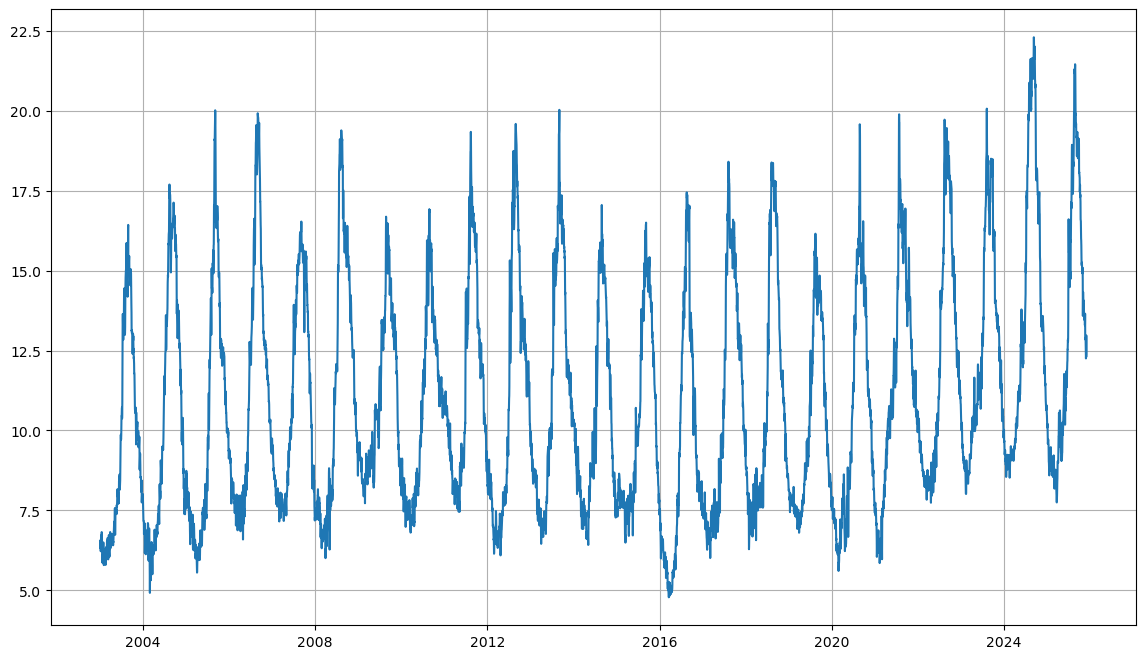

In [66]:
fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
ax.plot(sstd.time,sstd-273)
ax.grid()

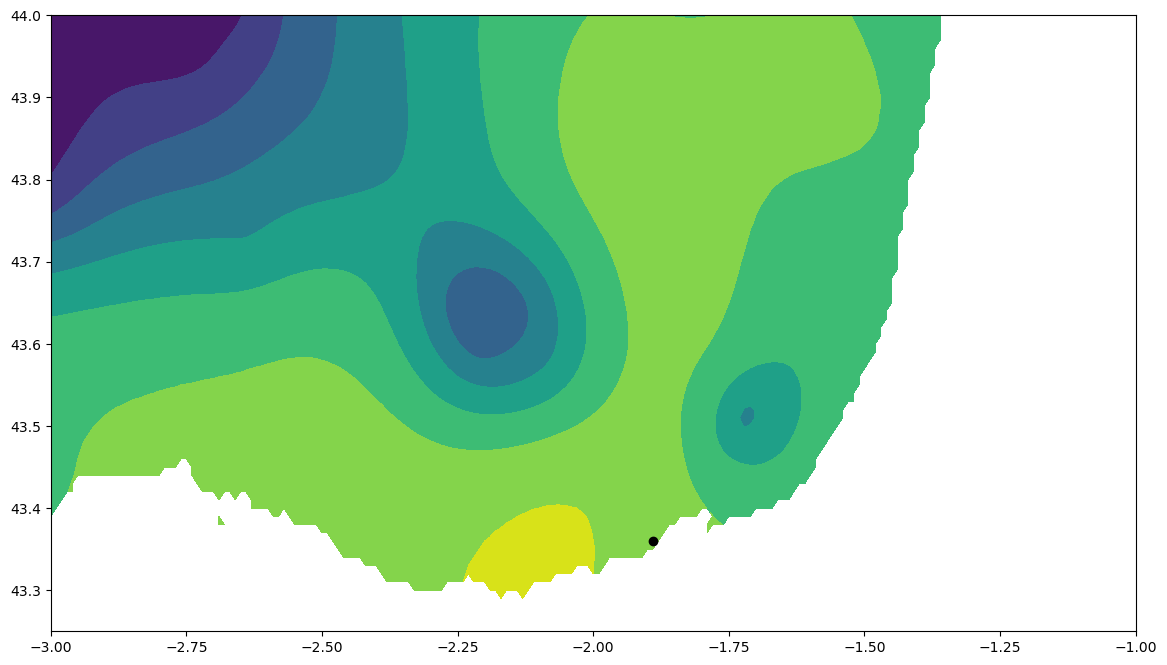

In [64]:
z=DS.analysed_sst[0,:,:].sel(lon=slice(-3,-1),lat=slice(43.25,44)).load()

fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
ax.contourf(z.lon,z.lat,z-273)
for i1 in range(0,1):
    ax.plot(Xr[i1],Yr[i1],'ok')


In [53]:
DS.lon

<xarray.DataArray 'lon' (lon: 36000)> Size: 144kB
array([-179.99, -179.98, -179.97, ...,  179.98,  179.99,  180.  ],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      longitude
    standard_name:  longitude
    axis:           X
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0
    comment:        none

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (301, 0)

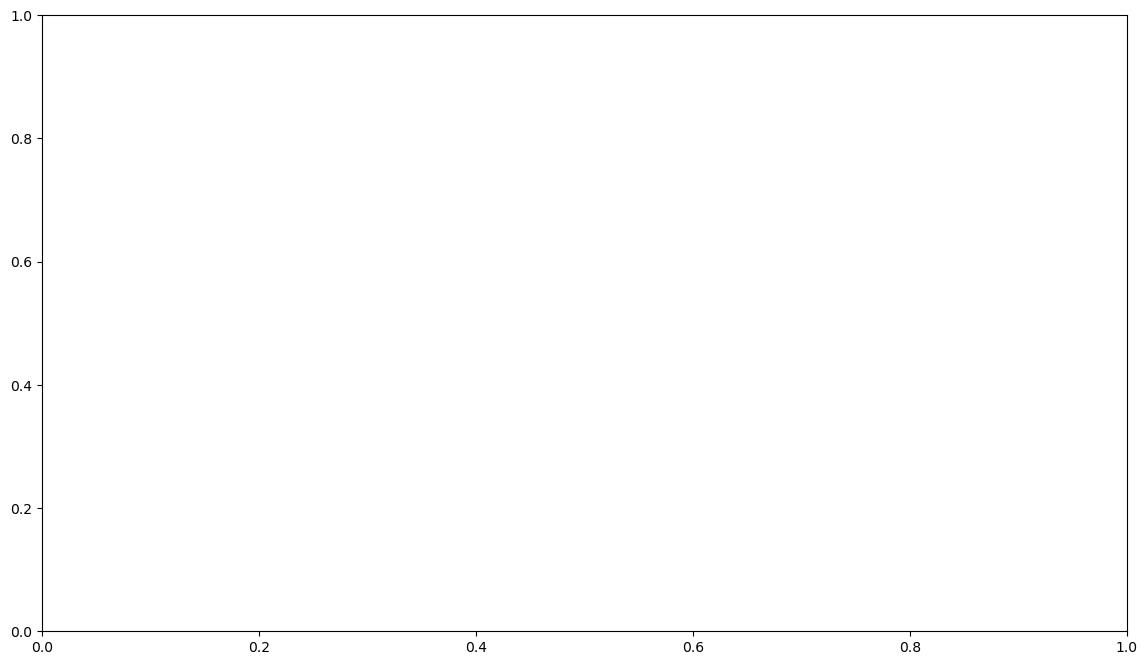

In [52]:
fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
ax.contourf(z.lon,z.lat,z)


In [ ]:
for i1 in range(0,1):
    ax.plot(Xr[i1],Yr[i1],'ok')

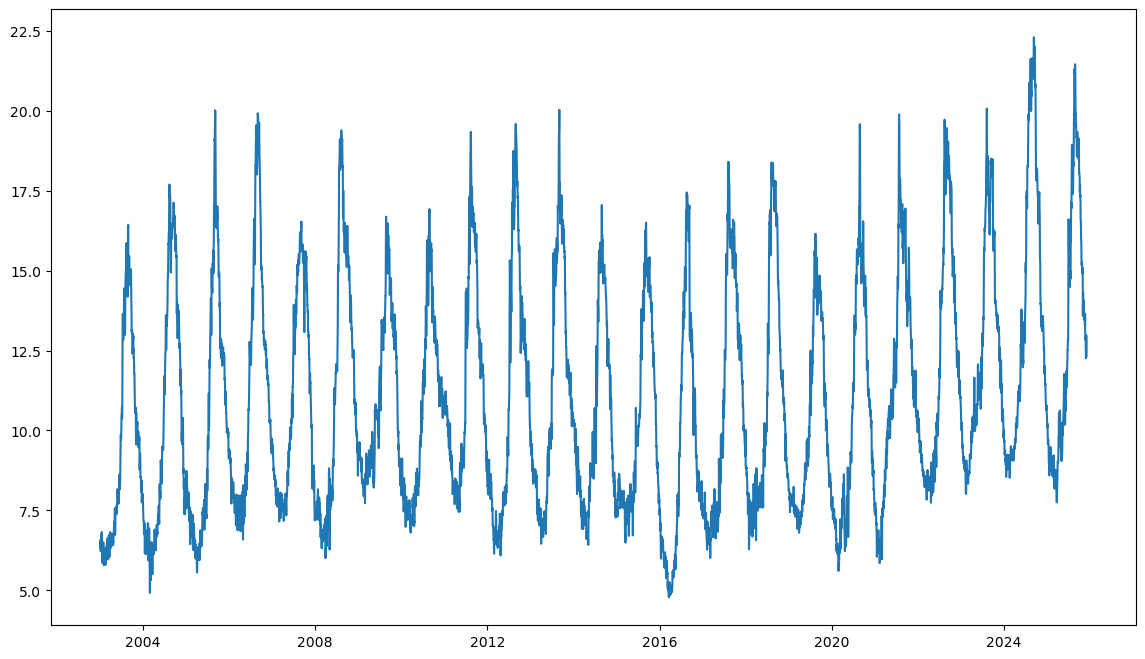

In [23]:
fig